# Introduction
This notebook is an implementation of experiments described in the paper "Towards story-related classification of movie scenes", submitted to the collection of "Science of Stories", at Plos One (url to be updated after acceptance).

In [1]:
import os
import re
from fractions import Fraction
import pandas as pd
import numpy as np
from numpy.linalg import norm
import shap
import xgboost

from scipy.stats import entropy, ttest_rel, sem

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import normalize
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier
from xgboost import plot_importance

from collections import Counter

from matplotlib import pyplot
import matplotlib.pyplot as plt

In [2]:
SEASON_EP = {'1': 28,
             '2': 32,
             '3': 1}
def generate_ep(SEASON_EP):
    ep_list = []
    for season in SEASON_EP:
        ep_list += ['S'+season+'E'+str(ep) for ep in range(1, SEASON_EP[season]+1)]
    ep_list.remove('S1E1')
    return ep_list

EP_LIST = generate_ep(SEASON_EP)

group_ep = {}
for i in range(60):
    group_ep[str(i+1)] = EP_LIST[i]

label_list = list([
    "Inciting incident",
    "Climax 1",
    "Obstacle",
    "Midpoint",
    "Disaster",
    "Crisis",
    "Climax 2",
    "Climax 3",
    "Wrap-up",
    "Non-Key"
])

reduce_list = [
    #"Midpoint",
    #"Disaster",
    #"Crisis",
    #"Climax 2",
    "Climax 3",
    "Wrap-up",
    "Non-Key"
]

In [3]:
def label_string_to_tuple(y, class_reduce_list=[]):
    """
    Originally, the annotations are in the format of strings.
    We need to convert it into tuple format for future operating.
    
    @input: df_label, a DataFrame format data structure that is read from csv using pd.read_csv()
    @output: labels_tuple, a list, each element is a list of tuples: (label, prob)
    """
    
    y_tuple = []
    
    for label in y['Label'].values:
        labels = re.findall('\(([^)]+)', label[1:-1])
        label_per_scene = []
        prob_nk = 0
        for l in labels:
            lab = l.split(',')[0][1:-1]
            prob = float(l.split(',')[1][1:])
            if lab in class_reduce_list:
                prob_nk += prob
            else:
                label_per_scene.append((lab, prob))
        if prob_nk != 0:
            label_per_scene.append(('Non-Key', prob_nk))
        scene_label = np.array(label_per_scene, dtype=object)
        y_tuple.append(scene_label)
    return np.array(y_tuple)

def find_least_multiple(y_tuple):
    """
    """
    num_annotators = []
    
    for scene in y_tuple:
        for s in scene:
            num_annotators.append(Fraction(s[1]).limit_denominator().denominator)
#         num_annotators.append(len(scene))
    unique = np.unique(num_annotators)
    least_multiple = np.lcm.reduce(unique)
    print("Found least common multiple: ", least_multiple)
    
    return least_multiple

def oversample_label(y_tuple, scale):  
    """
    """
    oversampled_label = []
    for scene in y_tuple:
        oversampled_scene_labels = []
        for i in range(1, len(scene) + 1):
            oversampled_scene_labels += [scene[i-1][0]] * round(scene[i-1][1] * int(scale))
        oversampled_label.append(oversampled_scene_labels)
        
    oversample_label = np.array(oversampled_label)
    print(oversample_label.shape)
    
    y_sampled = []
    for i in range(oversample_label.shape[1]):
        y_sampled += list(oversample_label[:,i])
    
    return np.array(y_sampled)

def least_multiple_oversample(X, y):
    """
    """
    oversample_scale = find_least_multiple(y)
    
    # oversample features
    X_sampled = np.tile(X, (oversample_scale, 1))

    # oversample labels
    y_sampled = oversample_label(y, oversample_scale)
    
    return X_sampled, y_sampled, oversample_scale

def label_to_numbers(y_sampled):
    y_number_sampled = []
    
    for y in y_sampled:
        y_number_sampled.append(label_list.index(y) + 1)
        
    return np.array(y_number_sampled)

In [4]:
## First we load the data

raw_feature_dir = './data/features/'
raw_label_dir = './data/labels/'

feature_list = ['id', 'clos_beg_id', 'r_id_loc', 'start_time', 'dur', 'r_t_loc', 'sec', 
                'clock_drift', 'protagonist_appear', 'ava_charNet_score']

def load_data(EP_LIST, 
              sample=True, 
              class_reduce=False, 
              return_tuple=False):
    X_column_headers = feature_list
    y_column_headers = ['Label']
    X = pd.DataFrame(columns=X_column_headers)
    y = pd.DataFrame(columns=y_column_headers)
    
    for ep in EP_LIST:
        data_file = raw_feature_dir + ep + '-Scenes.csv'
        label_file = raw_label_dir + 'Final_Labels_' + ep + '.csv'
        
        ep_df = pd.read_csv(data_file, usecols=X_column_headers)
        label_df = pd.read_csv(label_file, header=None, usecols=[1] ,names=y_column_headers)
        
        X = X.append(ep_df, sort=False)
        y = pd.concat([y, label_df])
    if not class_reduce:
        y_tuple = label_string_to_tuple(y)
    else:
        y_tuple = label_string_to_tuple(y, class_reduce_list=reduce_list)
    
    if sample:
        X_data, y_data, scale = least_multiple_oversample(X.values, y_tuple)
        y_data = label_to_numbers(y_data)
    else:
        pass
    
    if return_tuple:
        return y_tuple
    else:
        return X_data, y_data, scale

def group_generation(X, scale):
    scene_id = list(X[:int(len(X)/scale),0])
    group_ep = []

    num_scenes = []
    count = 1
    for i in range(len(scene_id)):
        if scene_id[i] == 1.0:
            num_scenes.append(count)
            count = 1
        else:
            count += 1

    num_scenes.remove(1.0)
    num_scenes.append(scene_id[-1])

    for i in range(1, len(num_scenes) + 1):
        group_ep += [i] * int(num_scenes[i-1])
    
    groups = group_ep * scale
    return groups

## Data statistics

In [5]:
def get_scene_majority(scene_annotations):
    if len(scene_annotations) == 1:
        label = scene_annotations[0][0]
        prob = scene_annotations[0][1]
        return label, prob
    else:
        for annotation in scene_annotations:
            label = annotation[0]
            prob = annotation[1]
            if prob >= 0.5:
                return label, prob
    return None, None

In [6]:
y_tuple = load_data(EP_LIST, return_tuple=True)

Found least common multiple:  60
(1569, 60)


In [7]:
label_statistic = {
    'disagree': 0,
    'agree': 0,
    'major_nk': 0,
    'all_nk': 0,
    'major_k': 0,
    'all_k': 0
}
for a in y_tuple:
    label, prob = get_scene_majority(a)
    if not label:
        label_statistic['disagree'] += 1
    else:
        label_statistic['agree'] += 1
        if label == 'Non-Key':
            label_statistic['major_nk'] += 1
            if prob == 1.0:
                label_statistic['all_nk'] += 1
        else:
            label_statistic['major_k'] += 1
            if prob == 1.0:
                label_statistic['all_k'] += 1

In [8]:
label_statistic

{'disagree': 117,
 'agree': 1452,
 'major_nk': 999,
 'all_nk': 625,
 'major_k': 453,
 'all_k': 92}

In [9]:
fig, ax = plt.subplots(figsize=(10,10))


size = 0.3
vals = np.array([[label_statistic['major_nk'], label_statistic['major_k']], 
                 [label_statistic['disagree'], 0]])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4)
inner_colors = cmap(np.array([1, 2, 5, 6]))

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal")
plt.savefig('Nested Pie charts - agreement.png')
plt.close()

In [10]:
X, y, scale = load_data(EP_LIST)
GROUP_EP=group_generation(X, scale)

Found least common multiple:  60
(1569, 60)


In [11]:
X_reduced, y_reduced, scale = load_data(EP_LIST, class_reduce=True)

Found least common multiple:  60
(1569, 60)


In [12]:
print(X.shape, y.shape)

(94140, 10) (94140,)


In [13]:
def sampling_restore(X_sampled, y_sampled):
    if int(len(X_sampled)/60) != int(len(y_sampled)/60):
        print("Wrong shape when doing sampling restore!")
    
    ep_len = int(len(X_sampled)/60)
    X_restore = X_sampled[:ep_len]

    y_restore = np.zeros((ep_len, len(label_list)))

    for i, label in enumerate(y_sampled):
        y_restore[i%ep_len, (label-1)] += 1

    y_restore = y_restore/60
    
    if not reduce_list:
        return X_restore, y_restore
    else:
        reduce_idx = np.array([label_list.index(l) for l in reduce_list if l != 'Non-Key'])
        y_restore = np.delete(y_restore, reduce_idx, axis=1)
        return X_restore, y_restore

def full_label_vector(y):
    y_full = np.zeros((y.shape[0], len(label_list)), dtype=np.float32)
    for index, new_y in enumerate(y_full):
        for annotation in y[index]:
            label, prob = annotation[0], annotation[1]
            new_y[label_list.index(label)] = prob  
    return y_full

In [14]:
def compute_kl_divergence(pk, qk):
    '''
    pk: true distribution
    qk: predicted distribution
    '''
    return entropy(pk, qk)

def compute_cosine_similarity(pk, qk):
    return np.inner(pk, qk)/(norm(pk) * norm(qk))

In [15]:
the_model = None
model_label_similarity = {'Logistic': [],
                          'XGBoost': [],
                          'XGBoost_basic': [],
                          'XGBoost_Label_reduce': []
                         }

model_kl_divergence = {'Logistic': [],
                       'XGBoost': [],
                       'XGBoost_basic': [],
                       'XGBoost_Label_reduce': []
                      }

In [16]:
model_label_similarity_back = model_label_similarity
model_kl_divergence_back = model_kl_divergence

In [17]:
model_label_similarity = model_label_similarity_back
model_kl_divergence = model_kl_divergence_back

In [18]:
## Implementation of our customized score function
## It measure the similarity between predict class probability vectors and the true class distribution
def similarity_scoring(model, X, y):
    X_restore, y_restore = sampling_restore(X, y)
    y_predict_proba = model.predict_proba(X_restore)
    
    if the_model not in model_label_similarity:
        model_label_similarity[the_model] = []
    
    similarity = np.zeros(y_restore.shape[0])
    if y_restore.shape == y_predict_proba.shape:
        for i in range(y_restore.shape[0]):
            similarity[i] = compute_cosine_similarity(y_restore[i], y_predict_proba[i])
    else:
        print("Wrong shape when calculating similarity!")
        print("Predicted shape: ", y_predict_proba.shape)
        print("Restored shape: ", y_restore.shape)
    
    label_similarity = np.zeros((y_restore.shape[1]))
    for i in range(y_restore.shape[1]):
        label_similarity[i] = compute_cosine_similarity(y_restore[:, i], y_predict_proba[:, i])
    
    model_label_similarity[the_model].append(label_similarity)
    
    return np.average(similarity)

def kl_divergence_scoring(model, X, y):
    X_restore, y_restore = sampling_restore(X, y)
    y_predict_proba = model.predict_proba(X_restore)
    
    if the_model not in model_kl_divergence:
        model_kl_divergence[the_model] = []
    
    kl_divergence = np.zeros(y_restore.shape[0])
    if y_restore.shape == y_predict_proba.shape:
        for i in range(y_restore.shape[0]):
            #Negative KL divergence because we need the score to be the higher the better.
            kl_divergence[i] = -compute_kl_divergence(y_restore[i], y_predict_proba[i])
    else:
        print("Wrong shape when calculating kl divergence!")
    
    label_kl_divergence = np.zeros((y_restore.shape[1]))
    for i in range(y_restore.shape[1]):
        label_kl_divergence[i] = compute_kl_divergence(y_restore[:, i], y_predict_proba[:, i])
        

    model_kl_divergence[the_model].append(label_kl_divergence)
    
    return np.average(kl_divergence)

In [14]:
# Logistic Regression Baseline
X_normed = normalize(X, axis=0)

logo = LeaveOneGroupOut()
split = logo.split(X_normed, y, GROUP_EP)
scoring = {'Similarity': similarity_scoring,
           'KL_divergence': kl_divergence_scoring}

model = LogisticRegression(solver='lbfgs', multi_class='multinomial')

the_model = 'Logistic'

logistic_baseline = cross_validate(model, X_normed, y, cv=split, 
                                    scoring=scoring, 
                                    return_train_score=False, return_estimator=True, verbose=3)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV]  , Similarity=0.6660685090031891, KL_divergence=-1.092939051113129, total=   2.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  , Similarity=0.7383103204931627, KL_divergence=-0.9706021390827728, total=   1.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV]  , Similarity=0.5115459113017179, KL_divergence=-1.7026951786197824, total=   1.9s
[CV]  ................................................................
[CV]  , Similarity=0.7054811813809923, KL_divergence=-1.1267536871390493, total=   2.1s
[CV]  ................................................................
[CV]  , Similarity=0.5677265765584614, KL_divergence=-1.391448733300194, total=   1.7s
[CV]  ................................................................


/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.8252107284494249, KL_divergence=-0.8196588192156101, total=   1.8s
[CV]  ................................................................
[CV]  , Similarity=0.5847847265662565, KL_divergence=-1.1678673532378072, total=   1.7s
[CV]  ................................................................
[CV]  , Similarity=0.7647450616564166, KL_divergence=-0.88895202810827, total=   2.3s
[CV]  ................................................................
[CV]  , Similarity=0.7171548569610094, KL_divergence=-1.0200658420777384, total=   2.7s
[CV]  ................................................................
[CV]  , Similarity=0.7813837495827097, KL_divergence=-0.8975484320434748, total=   1.7s
[CV]  ................................................................
[CV]  , Similarity=0.8541739322284887, KL_divergence=-0.726595493224175, total=   1.7s
[CV]  ................................................................
[CV]  , Similarity=0.5755550783127922, KL_diverge

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.7118904952153989, KL_divergence=-1.0163294971613568, total=   1.5s
[CV]  ................................................................
[CV]  , Similarity=0.6788340945315302, KL_divergence=-1.1645867158031193, total=   1.5s
[CV]  ................................................................
[CV]  , Similarity=0.8475222605964952, KL_divergence=-0.7603226869047925, total=   1.6s
[CV]  ................................................................
[CV]  , Similarity=0.708303613348997, KL_divergence=-1.1424017438488796, total=   1.6s
[CV]  ................................................................
[CV]  , Similarity=0.83835812238506, KL_divergence=-0.7917152269539781, total=   1.5s
[CV]  ................................................................
[CV]  , Similarity=0.7543911065492438, KL_divergence=-0.9478553025400105, total=   1.7s
[CV]  ................................................................
[CV]  , Similarity=0.8487610643813763, KL_diverge

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.7890042805898513, KL_divergence=-0.9310379178463694, total=   1.7s
[CV]  ................................................................
[CV]  , Similarity=0.7185178281337847, KL_divergence=-1.0778455587706122, total=   1.7s
[CV]  ................................................................
[CV]  , Similarity=0.7984422116404236, KL_divergence=-0.8352302182101441, total=   2.0s
[CV]  ................................................................
[CV]  , Similarity=0.6214696294798593, KL_divergence=-1.1609085358312752, total=   2.2s
[CV]  ................................................................
[CV]  , Similarity=0.6800534633570522, KL_divergence=-1.1911666922972304, total=   2.2s
[CV]  ................................................................
[CV]  , Similarity=0.8076833080934599, KL_divergence=-0.8622572223060659, total=   1.7s
[CV]  ................................................................
[CV]  , Similarity=0.8046800120038082, KL_dive

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.8min finished


In [27]:
print('Logistic_regression similarity: ava. %.3f, std. %.3f' % 
      (np.average(logistic_baseline['test_Similarity']), sem(logistic_baseline['test_Similarity'])))

print('Logistic_regression kl_divergence: ava. %.3f, std. %.3f' % 
      (np.average(-logistic_baseline['test_KL_divergence']), sem(-logistic_baseline['test_KL_divergence'])))

NameError: name 'logistic_baseline' is not defined

In [16]:
np.count_nonzero(~np.isnan(model_label_similarity['Logistic']), axis=0)

array([60, 60, 60, 60, 59, 58, 60, 60, 59, 60])

In [17]:
np.count_nonzero(~np.isnan(model_kl_divergence['Logistic']), axis=0)

array([60, 60, 60, 60, 59, 58, 60, 60, 59, 60])

In [18]:
print('Label similarity, logistic_regression:')
print(np.nanmean(model_label_similarity['Logistic'], axis=0))
print(sem(model_label_similarity['Logistic'], axis=0, nan_policy='omit'))

Label similarity, logistic_regression:
[0.39681255 0.30731824 0.43604488 0.31855511 0.29038782 0.27896306
 0.34265871 0.28815421 0.24543012 0.8522055 ]
[0.0103945552203636 0.010760821066093789 0.011048450063420564
 0.01045791082063875 0.011179893658396783 0.010030956839975213
 0.010397671834218756 0.009022410356482902 0.005538135756269406
 0.007970536693395938]


In [19]:
print('Label kl_divergence, logistic_regression:')
print(np.nanmean(model_kl_divergence['Logistic'], axis=0))
print(sem(model_kl_divergence['Logistic'], axis=0, nan_policy='omit'))

Label kl_divergence, logistic_regression:
[1.94221775 2.45344329 1.64057095 2.33842889 2.58801494 2.65900122
 2.24461334 2.62540847 2.94150719 0.28739579]
[0.06040955106577388 0.06897400493097892 0.05430068546893383
 0.06383541765513992 0.07181458102070792 0.06769048860374526
 0.05890117881374444 0.062310744444273494 0.04863056666285239
 0.018756049387736236]


In [19]:
# All features
scoring = {'Similarity': similarity_scoring,
           'KL_divergence': kl_divergence_scoring}

X_normed = normalize(X, axis=0)

the_model = 'XGBoost'
reduce_list = []

logo = LeaveOneGroupOut()
split = logo.split(X_normed, y, GROUP_EP)
model = OneVsRestClassifier(XGBClassifier())

scores_ova_xgb_all = cross_validate(model, X_normed, y, cv=split, 
                                    scoring=scoring, 
                                    return_train_score=False, return_estimator=True, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV]  , Similarity=0.7138235077064666, KL_divergence=-0.8266503486031361, total=  36.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.3s remaining:    0.0s


[CV]  , Similarity=0.8347373439604795, KL_divergence=-0.5791631022901615, total=  53.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV]  , Similarity=0.5582646803510749, KL_divergence=-1.2882277483229942, total=  48.8s
[CV]  ................................................................
[CV]  , Similarity=0.8710291069359856, KL_divergence=-0.473607633104652, total=  43.5s
[CV]  ................................................................
[CV]  , Similarity=0.6788926662626152, KL_divergence=-0.8856643628598718, total=  39.9s
[CV]  ................................................................


/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.8426353334098902, KL_divergence=-0.6170708086526898, total=  37.4s
[CV]  ................................................................
[CV]  , Similarity=0.8299916765428741, KL_divergence=-0.4513674806412177, total=  38.6s
[CV]  ................................................................
[CV]  , Similarity=0.861756959794493, KL_divergence=-0.5040028250877037, total=  33.6s
[CV]  ................................................................
[CV]  , Similarity=0.7231543638962197, KL_divergence=-0.9399389536012497, total=  30.8s
[CV]  ................................................................
[CV]  , Similarity=0.8448083141191094, KL_divergence=-0.5996083556423979, total=  36.3s
[CV]  ................................................................
[CV]  , Similarity=0.8842914223432471, KL_divergence=-0.5426226286519642, total=  33.4s
[CV]  ................................................................
[CV]  , Similarity=0.7044173467346267, KL_diver

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.863446012441509, KL_divergence=-0.5203623493826635, total=  42.1s
[CV]  ................................................................
[CV]  , Similarity=0.8220106740704014, KL_divergence=-0.5657981785213458, total=  47.2s
[CV]  ................................................................
[CV]  , Similarity=0.9106003916235101, KL_divergence=-0.41862385068717956, total=  46.3s
[CV]  ................................................................
[CV]  , Similarity=0.7862493784895487, KL_divergence=-0.8413737988831768, total=  42.4s
[CV]  ................................................................
[CV]  , Similarity=0.8833218930193876, KL_divergence=-0.5008526220978784, total=  47.5s
[CV]  ................................................................
[CV]  , Similarity=0.840440208549801, KL_divergence=-0.6473798683894173, total=  40.8s
[CV]  ................................................................
[CV]  , Similarity=0.8901235424559325, KL_diver

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.7864102819780159, KL_divergence=-0.6987579926630494, total=  33.0s
[CV]  ................................................................
[CV]  , Similarity=0.8205054388348016, KL_divergence=-0.5560934007364238, total=  32.5s
[CV]  ................................................................
[CV]  , Similarity=0.8739461352224681, KL_divergence=-0.48353284211117076, total=  45.6s
[CV]  ................................................................
[CV]  , Similarity=0.7777404058466835, KL_divergence=-0.6459200902639791, total=  41.7s
[CV]  ................................................................
[CV]  , Similarity=0.7272870480206556, KL_divergence=-0.8419145398953677, total=  34.7s
[CV]  ................................................................
[CV]  , Similarity=0.8217846239419468, KL_divergence=-0.7524384295379198, total=  34.2s
[CV]  ................................................................
[CV]  , Similarity=0.842227397091243, KL_dive

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 41.7min finished


In [28]:
print('XGBoost similarity: ava. %.3f, std. %.3f' % 
      (np.average(scores_ova_xgb_all['test_Similarity']), sem(scores_ova_xgb_all['test_Similarity'])))

print('XGBoost kl_divergence: ava. %.3f, std. %.3f' % 
      (np.average(-scores_ova_xgb_all['test_KL_divergence']), sem(-scores_ova_xgb_all['test_KL_divergence'])))

XGBoost similarity: ava. 0.806, std. 0.009
XGBoost kl_divergence: ava. 0.668, std. 0.023


In [22]:
np.count_nonzero(~np.isnan(model_kl_divergence['XGBoost']), axis=0)

array([60, 60, 60, 60, 59, 58, 60, 60, 59, 60])

In [23]:
print('Label similarity, XGBoost:')
print(np.nanmean(model_label_similarity['XGBoost'], axis=0))
print(sem(model_label_similarity['XGBoost'], axis=0, nan_policy='omit'))

Label similarity, XGBoost:
[0.66709136 0.59020341 0.52033838 0.41998875 0.42481847 0.37981626
 0.51842901 0.64798601 0.88817035 0.9011951 ]
[0.031115688584546598 0.0310974329007635 0.019180633135531904
 0.028917820463926335 0.03485760598426559 0.03301419728205311
 0.029244596261169865 0.03479539808956835 0.031367616152629285
 0.00790185745099855]


In [24]:
print('Label kl_divergence, XGBoost:')
print(np.nanmean(model_kl_divergence['XGBoost'], axis=0))
print(sem(model_kl_divergence['XGBoost'], axis=0, nan_policy='omit'))

Label kl_divergence, XGBoost:
[1.19994831 1.40314008 1.35840234 1.95879272 2.06564567 2.19657656
 1.60004081 1.0775122  0.49107016 0.21393546]
[0.0875762769349859 0.09473523033050071 0.06476402371114441
 0.10968270403013756 0.14458415521384205 0.12488462441997683
 0.10815179414931496 0.09588225213614898 0.16575944794036807
 0.019554795912735855]


In [21]:
# Basic feature

scoring = {'Similarity': similarity_scoring,
           'KL_divergence': kl_divergence_scoring}

the_model = 'XGBoost_basic'

X_basic = X[:, :-3]
X_normed_basic = normalize(X_basic, axis=0)

logo = LeaveOneGroupOut()
split = logo.split(X_normed_basic, y, GROUP_EP)
model = OneVsRestClassifier(XGBClassifier())

scores_ova_xgb_basic = cross_validate(model, X_normed_basic, y, cv=split, scoring=scoring, 
                                      return_train_score=False, return_estimator=True, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV]  , Similarity=0.706554221595547, KL_divergence=-0.8830297899056537, total=  24.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.2s remaining:    0.0s


[CV]  , Similarity=0.8319899315188548, KL_divergence=-0.5835686220582409, total=  22.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.9s remaining:    0.0s


[CV]  , Similarity=0.5455090581577722, KL_divergence=-1.3303706708796301, total=  23.7s
[CV]  ................................................................
[CV]  , Similarity=0.8708802472256227, KL_divergence=-0.47752130162041007, total=  26.1s
[CV]  ................................................................
[CV]  , Similarity=0.689549464022607, KL_divergence=-0.8485166406024476, total=  34.2s
[CV]  ................................................................


/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.8531805189928987, KL_divergence=-0.5933282731030746, total=  30.7s
[CV]  ................................................................
[CV]  , Similarity=0.8336152725970988, KL_divergence=-0.45324140332249147, total=  30.1s
[CV]  ................................................................
[CV]  , Similarity=0.8656217912117984, KL_divergence=-0.49293004512689015, total=  31.1s
[CV]  ................................................................
[CV]  , Similarity=0.741818278575745, KL_divergence=-0.933370356849378, total=  30.5s
[CV]  ................................................................
[CV]  , Similarity=0.8453765300891429, KL_divergence=-0.5994086222538464, total=  27.0s
[CV]  ................................................................
[CV]  , Similarity=0.884440326415443, KL_divergence=-0.5391061666220661, total=  22.3s
[CV]  ................................................................
[CV]  , Similarity=0.7052129152128799, KL_diver

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.8625439100303732, KL_divergence=-0.520687820244634, total=  29.5s
[CV]  ................................................................
[CV]  , Similarity=0.8214197012067099, KL_divergence=-0.5599630742196527, total=  32.2s
[CV]  ................................................................
[CV]  , Similarity=0.9080484421411272, KL_divergence=-0.42281839110680025, total=  32.9s
[CV]  ................................................................
[CV]  , Similarity=0.779346369819698, KL_divergence=-0.8472227902464501, total=  33.8s
[CV]  ................................................................
[CV]  , Similarity=0.8842030445897038, KL_divergence=-0.4950240135503232, total=  35.8s
[CV]  ................................................................
[CV]  , Similarity=0.8502507352340298, KL_divergence=-0.5995360917628944, total=  27.0s
[CV]  ................................................................
[CV]  , Similarity=0.90224634669369, KL_diverge

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.783526658895327, KL_divergence=-0.7020855285744867, total=  22.1s
[CV]  ................................................................
[CV]  , Similarity=0.8381653191545181, KL_divergence=-0.5206495207456295, total=  22.2s
[CV]  ................................................................
[CV]  , Similarity=0.8781905377776428, KL_divergence=-0.48852550489454266, total=  22.5s
[CV]  ................................................................
[CV]  , Similarity=0.7798595923064746, KL_divergence=-0.6356650051336213, total=  24.9s
[CV]  ................................................................
[CV]  , Similarity=0.7499323549639111, KL_divergence=-0.8002795703741654, total=  22.4s
[CV]  ................................................................
[CV]  , Similarity=0.8105566270156357, KL_divergence=-0.7675597791198284, total=  22.2s
[CV]  ................................................................
[CV]  , Similarity=0.8426997307918443, KL_dive

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 25.9min finished


In [22]:
print('XGBoost_basic similarity: ava. %.3f, std. %.3f' % 
      (np.average(scores_ova_xgb_basic['test_Similarity']), sem(scores_ova_xgb_basic['test_Similarity'])))

print('XGBoost_basic kl_divergence: ava. %.3f, std. %.3f' % 
      (np.average(-scores_ova_xgb_basic['test_KL_divergence']), sem(-scores_ova_xgb_basic['test_KL_divergence'])))

XGBoost_basic similarity: ava. 0.808, std. 0.009
XGBoost_basic kl_divergence: ava. 0.663, std. 0.023


In [28]:
print('Label similarity, XGBoost_basic:')
print(np.nanmean(model_label_similarity['XGBoost_basic'], axis=0))
print(sem(model_label_similarity['XGBoost_basic'], axis=0, nan_policy='omit'))

Label similarity, XGBoost_basic:
[0.66772135 0.58098244 0.52069817 0.41130185 0.43329407 0.36635892
 0.53250524 0.66176313 0.89344334 0.90243347]
[0.03138088908106871 0.031316666151705565 0.018946670415924703
 0.028172518930573293 0.03338685361380185 0.03257181966069677
 0.02990588557058852 0.03545228138408217 0.02975692853775661
 0.008152491448584702]


In [29]:
print('Label kl_divergence, XGBoost_basic:')
print(np.nanmean(model_kl_divergence['XGBoost_basic'], axis=0))
print(sem(model_kl_divergence['XGBoost_basic'], axis=0, nan_policy='omit'))

Label kl_divergence, XGBoost_basic:
[1.19562096 1.42884629 1.35243266 1.96036933 2.01300152 2.23514002
 1.56288003 1.06364443 0.48491121 0.21159819]
[0.08767547217414529 0.0982546696378912 0.06595498857318845
 0.10148275323451107 0.13473647924990612 0.12613647207990267
 0.10739710522067157 0.09825663913678881 0.16395453100284746
 0.020203324608377895]


In [30]:
# Basic feature + vtc

scoring = {'Similarity': similarity_scoring,
           'KL_divergence': kl_divergence_scoring}

X_basic_vtc = X[:, :-2]
X_normed_basic_vtc = normalize(X_basic_vtc, axis=0)

the_model = 'XGBoost_basic_twoclock'

logo = LeaveOneGroupOut()
split = logo.split(X_normed_basic_vtc, y, GROUP_EP)
model = OneVsRestClassifier(XGBClassifier())

scores_ova_xgb_basic_vtc = cross_validate(model, X_normed_basic_vtc, y, cv=split, scoring=scoring, 
                                          return_train_score=False, return_estimator=True, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV]  , Similarity=0.7182933039138403, KL_divergence=-0.8308351203484579, total=  29.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.8s remaining:    0.0s


[CV]  , Similarity=0.8347249797348013, KL_divergence=-0.5772144005954225, total=  33.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV]  , Similarity=0.5395920262813201, KL_divergence=-1.3123646272968026, total=  30.6s
[CV]  ................................................................
[CV]  , Similarity=0.8507966042794339, KL_divergence=-0.5079731018455294, total=  36.6s
[CV]  ................................................................
[CV]  , Similarity=0.6913149690210261, KL_divergence=-0.8427859274781515, total=  37.4s
[CV]  ................................................................


/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.8474339417247608, KL_divergence=-0.5937803082273414, total=  30.5s
[CV]  ................................................................
[CV]  , Similarity=0.82623482195342, KL_divergence=-0.4422335590876118, total=  30.0s
[CV]  ................................................................
[CV]  , Similarity=0.8695905453210074, KL_divergence=-0.4857517209825918, total=  26.0s
[CV]  ................................................................
[CV]  , Similarity=0.7379309527708335, KL_divergence=-0.9493650484451465, total=  25.1s
[CV]  ................................................................
[CV]  , Similarity=0.8436779254465777, KL_divergence=-0.5825280957228938, total=  27.8s
[CV]  ................................................................
[CV]  , Similarity=0.887138099213275, KL_divergence=-0.5340586531969805, total=  28.4s
[CV]  ................................................................
[CV]  , Similarity=0.6994715564407193, KL_diverge

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.8627710128541515, KL_divergence=-0.5286820352834484, total=  29.6s
[CV]  ................................................................
[CV]  , Similarity=0.8203072615445102, KL_divergence=-0.5758854854298141, total=  29.9s
[CV]  ................................................................
[CV]  , Similarity=0.9047765395602408, KL_divergence=-0.4236420075463099, total=  29.2s
[CV]  ................................................................
[CV]  , Similarity=0.7734285397062323, KL_divergence=-0.8541529598414443, total=  33.7s
[CV]  ................................................................
[CV]  , Similarity=0.8861174472447603, KL_divergence=-0.49233983793406616, total=  39.6s
[CV]  ................................................................
[CV]  , Similarity=0.848456598802673, KL_divergence=-0.6169537902214612, total=  28.8s
[CV]  ................................................................
[CV]  , Similarity=0.9023919643219842, KL_dive

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.7855828760908791, KL_divergence=-0.7042701629027064, total=  31.7s
[CV]  ................................................................
[CV]  , Similarity=0.8255760251831833, KL_divergence=-0.5376487274056119, total=  33.3s
[CV]  ................................................................
[CV]  , Similarity=0.8765119263933979, KL_divergence=-0.49411565408468056, total=  30.3s
[CV]  ................................................................
[CV]  , Similarity=0.7708456967132051, KL_divergence=-0.6572518867263115, total=  31.7s
[CV]  ................................................................
[CV]  , Similarity=0.7346804709408338, KL_divergence=-0.8329963411076758, total=  30.9s
[CV]  ................................................................
[CV]  , Similarity=0.8186588801313451, KL_divergence=-0.747773065484409, total=  33.1s
[CV]  ................................................................
[CV]  , Similarity=0.8380909036209179, KL_dive

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 31.5min finished


In [31]:
print('XGBoost_basic_twoclock similarity: ava. %.3f, std. %.3f' % 
      (np.average(scores_ova_xgb_basic_vtc['test_Similarity']), sem(scores_ova_xgb_basic_vtc['test_Similarity'])))

print('XGBoost_basic_twoclock kl_divergence: ava. %.3f, std. %.3f' % 
      (np.average(-scores_ova_xgb_basic_vtc['test_KL_divergence']), sem(-scores_ova_xgb_basic_vtc['test_KL_divergence'])))

XGBoost_basic_twoclock similarity: ava. 0.807, std. 0.009
XGBoost_basic_twoclock kl_divergence: ava. 0.666, std. 0.023


In [32]:
print('Label similarity, XGBoost_basic_twoclock:')
print(np.nanmean(model_label_similarity['XGBoost_basic_twoclock'], axis=0))
print(sem(model_label_similarity['XGBoost_basic_twoclock'], axis=0, nan_policy='omit'))

Label similarity, XGBoost_basic_twoclock:
[0.66324834 0.58686533 0.51977412 0.42462086 0.43533706 0.36623655
 0.52895931 0.65196591 0.89035652 0.90184358]
[0.03121905908882709 0.03215061406795535 0.019549302745846698
 0.028616176325914452 0.03375967017525571 0.031770994976427776
 0.02976086987671591 0.034834787813763854 0.03086571820733869
 0.008143205728349662]


In [33]:
print('Label kl_divergence, XGBoost_basic_twoclock:')
print(np.nanmean(model_kl_divergence['XGBoost_basic_twoclock'], axis=0))
print(sem(model_kl_divergence['XGBoost_basic_twoclock'], axis=0, nan_policy='omit'))

Label kl_divergence, XGBoost_basic_twoclock:
[1.21229926 1.41882827 1.35425765 1.93432531 2.03570194 2.22083552
 1.57494136 1.06939215 0.48515849 0.21213347]
[0.0888094915839906 0.09789880728867957 0.06577019432429701
 0.10921262517949422 0.13982216791116137 0.12255528675913586
 0.10559343905726143 0.095161781990422 0.16181449387617838
 0.0199161975566405]


In [25]:
# All features, class_reduced
scoring = {'Similarity': similarity_scoring,
           'KL_divergence': kl_divergence_scoring}

X_normed = normalize(X, axis=0)

the_model = 'XGBoost_Label_reduce'

logo = LeaveOneGroupOut()
split = logo.split(X_normed, y_reduced, GROUP_EP)
model = OneVsRestClassifier(XGBClassifier())

scores_ova_xgb_reduced_all = cross_validate(model, X_normed, y_reduced, cv=split, 
                                            scoring=scoring, 
                                            return_train_score=False, return_estimator=True, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV]  , Similarity=0.7306928344571707, KL_divergence=-0.7848181634112622, total=  21.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s remaining:    0.0s


[CV]  , Similarity=0.8566871243219347, KL_divergence=-0.5216029831397051, total=  22.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.1s remaining:    0.0s


[CV]  , Similarity=0.6248255258045062, KL_divergence=-1.0893419580332346, total=  22.4s
[CV]  ................................................................
[CV]  , Similarity=0.8970413950569037, KL_divergence=-0.39936313976742266, total=  23.5s
[CV]  ................................................................
[CV]  , Similarity=0.6858583882859731, KL_divergence=-0.8612981862635213, total=  21.8s
[CV]  ................................................................
[CV]  , Similarity=0.8602452646081375, KL_divergence=-0.5830656086609397, total=  21.6s
[CV]  ................................................................
[CV]  , Similarity=0.8805017069663466, KL_divergence=-0.32656429999073455, total=  24.0s
[CV]  ................................................................
[CV]  , Similarity=0.8759116628892155, KL_divergence=-0.4605156450307998, total=  25.9s
[CV]  ................................................................
[CV]  , Similarity=0.7797376377755543, KL_di

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.8671019726050084, KL_divergence=-0.497272034025434, total=  22.9s
[CV]  ................................................................
[CV]  , Similarity=0.8350690940386514, KL_divergence=-0.5212282252176859, total=  21.5s
[CV]  ................................................................
[CV]  , Similarity=0.9186855528913346, KL_divergence=-0.35935352180433966, total=  22.8s
[CV]  ................................................................
[CV]  , Similarity=0.8448136791786862, KL_divergence=-0.6512945715212206, total=  23.7s
[CV]  ................................................................
[CV]  , Similarity=0.9137026777116826, KL_divergence=-0.4421506721890065, total=  21.6s
[CV]  ................................................................
[CV]  , Similarity=0.8446667328456899, KL_divergence=-0.6251400545688586, total=  21.9s
[CV]  ................................................................
[CV]  , Similarity=0.897020788386928, KL_diver

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/liu/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[CV]  , Similarity=0.8244975779068062, KL_divergence=-0.5922775559262696, total=  21.1s
[CV]  ................................................................
[CV]  , Similarity=0.8405649726298805, KL_divergence=-0.48695112885546415, total=  21.3s
[CV]  ................................................................
[CV]  , Similarity=0.8911294585212237, KL_divergence=-0.44792298030554306, total=  21.4s
[CV]  ................................................................
[CV]  , Similarity=0.7936745260173794, KL_divergence=-0.6085338535061356, total=  23.8s
[CV]  ................................................................
[CV]  , Similarity=0.7387827301309116, KL_divergence=-0.814586527092419, total=  22.3s
[CV]  ................................................................
[CV]  , Similarity=0.8463883985051541, KL_divergence=-0.6026355997276466, total=  23.0s
[CV]  ................................................................
[CV]  , Similarity=0.8720237467175956, KL_div

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 23.3min finished


In [26]:
print('XGBoost_reduced similarity: ava. %.3f, std. %.3f' % 
      (np.average(scores_ova_xgb_reduced_all['test_Similarity']), sem(scores_ova_xgb_reduced_all['test_Similarity'])))

print('XGBoost_reduced kl_divergence: ava. %.3f, std. %.3f' % 
      (np.average(-scores_ova_xgb_reduced_all['test_KL_divergence']), sem(-scores_ova_xgb_reduced_all['test_KL_divergence'])))

XGBoost_reduced similarity: ava. 0.831, std. 0.008
XGBoost_reduced kl_divergence: ava. 0.594, std. 0.022


In [34]:
#label_dist = [0.0656, 0.0372, 0.0864, 0.0338, 0.0260, 0.0223, 0.0338, 0.0329, 0.0306, 0.6313]
def evaluation(X, y, 
               ignore_non_key=False, 
               rand_method=None, 
               label_dist=None, 
               label_temporal_dist=None,
               eval_method='similarity'
              ):
    
    X_restore, y_restore = sampling_restore(X, y)
    if ignore_non_key:
        y_restore = y_restore[:,:-1]
    y_rand_predict = np.zeros_like(y_restore)
    
    for i, y_true in enumerate(y_restore):
        if rand_method is None:
            prob = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0] if not ignore_non_key else [0, 0, 1.0, 0, 0, 0, 0, 0, 0]
        elif rand_method == 'dist':
            prob = label_dist if not ignore_non_key else label_dist[:-1]
        elif rand_method == 'temporal_dist':
            if ignore_non_key:
                label_temporal = label_temporal_dist[:, :-1]
            else:
                label_temporal = label_temporal_dist
            start_percentile = X_restore[i, feature_list.index('r_t_loc')]
            end_percentile = X_restore[i + 1, feature_list.index('r_t_loc')] if i < X_restore.shape[0] - 1 else None
            if i == X_restore.shape[0] - 1:
                #print(int(start_percentile//0.01))
                prob = np.average(label_temporal[int(start_percentile//0.01):], axis=0)
            elif int(start_percentile//0.01) == int(end_percentile//0.01):
                #print(int(start_percentile//0.01))
                prob = label_temporal[int(start_percentile//0.01)]
            else:
                #print(int(start_percentile//0.01), int(end_percentile//0.01))
                prob = np.average(label_temporal[int(start_percentile//0.01): int(end_percentile//0.01)], axis=0)
        #y_rand_predict[i] = prob
        y_rand_predict[i] = prob / np.sum(prob)
        #print(y_rand_predict[i])
        
    if eval_method == 'similarity':
        similarity = np.zeros(y_restore.shape[0],)
        for i in range(y_restore.shape[0]):
            similarity[i] = compute_cosine_similarity(y_restore[i], y_rand_predict[i])
        return np.nanmean(similarity)
    
    if eval_method == 'kl_divergence':
        kl_divergence = np.zeros(y_restore.shape[0])
        for i in range(y_restore.shape[0]):
            kl = compute_kl_divergence(y_restore[i], y_rand_predict[i])
            kl_divergence[i] = kl if kl != np.inf else compute_kl_divergence(y_restore[i], y_rand_predict[i] + 1e-10)
        return np.nanmean(kl_divergence)
        
    if eval_method == 'label_similarity':
        similarity = np.zeros((y_restore.shape[1]))
        for i in range(y_restore.shape[1]):
            similarity[i] = compute_cosine_similarity(y_restore[:, i], y_rand_predict[:, i])
        return similarity
    
    if eval_method == 'label_kl_divergence':
        kl_divergence = np.zeros((y_restore.shape[1]))
        for i in range(y_restore.shape[1]):
            kl = compute_kl_divergence(y_restore[:, i], y_rand_predict[:, i])
            kl_divergence[i] = kl if kl != np.inf else compute_kl_divergence(y_restore[:, i], y_rand_predict[:, i] + 1e-10)
        return kl_divergence       

In [196]:
bench_similarity_most_common = {
    'similarity': [],
    'kl_divergence': [],
    'label_similarity': [],
    'label_kl_divergence': []
}
for i in range(1, 61):
    test_data = X[np.array(GROUP_EP)==i]
    if not reduce_list:
        test_label = y[np.array(GROUP_EP)==i]
    else:
        test_label = y_reduced[np.array(GROUP_EP)==i]
    bench_similarity_most_common['similarity'].append(evaluation(test_data, test_label, eval_method='similarity'))
    bench_similarity_most_common['kl_divergence'].append(evaluation(test_data, test_label, eval_method='kl_divergence'))
    bench_similarity_most_common['label_similarity'].append(evaluation(test_data, test_label, eval_method='label_similarity'))
    bench_similarity_most_common['label_kl_divergence'].append(evaluation(test_data, test_label, eval_method='label_kl_divergence'))

ValueError: could not broadcast input array from shape (10) into shape (7)

In [190]:
print('Similarity, most common vector: ava. %.3f, std. %.3f' % 
      (np.average(bench_similarity_most_common['similarity']), sem(bench_similarity_most_common['similarity'])))
print('KL_divergence, most common vector: ava. %.3f, std. %.3f' % 
      (np.average(bench_similarity_most_common['kl_divergence']), sem(bench_similarity_most_common['kl_divergence'])))

Similarity, most common vector: ava. nan, std. nan
KL_divergence, most common vector: ava. nan, std. nan


/Users/liu/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/liu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/liu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/liu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/liu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [37]:
print('Label similarity, most common vector:')
print(np.nanmean(bench_similarity_most_common['label_similarity'], axis=0))
print(sem(bench_similarity_most_common['label_similarity'], axis=0, nan_policy='omit'))

Label similarity, most common vector:
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.83928258]
[-- -- -- -- -- -- -- -- -- 0.008636880347586928]


/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [38]:
print('Label kl_divergence, most common vector:')
print(np.nanmean(bench_similarity_most_common['label_kl_divergence'], axis=0))
print(sem(bench_similarity_most_common['label_kl_divergence'], axis=0, nan_policy='omit'))

Label kl_divergence, most common vector:
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.30388379]
[-- -- -- -- -- -- -- -- -- 0.019781841605005443]


/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [39]:
def compute_label_distribution(train_y):
    cnt = Counter(train_y)
    label_prob = sorted([(i, cnt[i] / len(train_y)) for i in cnt])
    return [pair[1] for pair in label_prob]  

In [40]:
bench_label_dist = {
    'similarity': [],
    'kl_divergence': [],
    'label_similarity': [],
    'label_kl_divergence': []
}
#bench_similarity_normal = []
for i in range(1, 61):
    train_y = y[np.array(GROUP_EP)!=i]
    label_dist = compute_label_distribution(train_y)
    test_data = X[np.array(GROUP_EP)==i]
    test_label = y[np.array(GROUP_EP)==i]
    bench_label_dist['similarity'].append(evaluation(test_data, test_label, 
                                                     rand_method='dist', 
                                                     label_dist=label_dist, 
                                                     eval_method='similarity'))
    bench_label_dist['kl_divergence'].append(evaluation(test_data, test_label, 
                                                        rand_method='dist', 
                                                        label_dist=label_dist, 
                                                        eval_method='kl_divergence'))
    bench_label_dist['label_similarity'].append(evaluation(test_data, test_label, 
                                                           rand_method='dist', 
                                                           label_dist=label_dist, 
                                                           eval_method='label_similarity'))
    bench_label_dist['label_kl_divergence'].append(evaluation(test_data, test_label, 
                                                              rand_method='dist', 
                                                              label_dist=label_dist, 
                                                              eval_method='label_kl_divergence'))

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [41]:
print('Similarity, label distribution: ava. %.3f, std. %.3f' % 
      (np.average(bench_label_dist['similarity']), sem(bench_label_dist['similarity'])))
print('KL_divergence, label distribution: ava. %.3f, std. %.3f' % 
      (np.average(bench_label_dist['kl_divergence']), sem(bench_label_dist['kl_divergence'])))

Similarity, label distribution: ava. 0.712, std. 0.013
KL_divergence, label distribution: ava. 1.090, std. 0.032


In [42]:
print('Label similarity, label distribution:')
print(np.nanmean(bench_label_dist['label_similarity'], axis=0))
print(sem(bench_label_dist['label_similarity'], axis=0, nan_policy='omit'))

Label similarity, label distribution:
[0.34374005 0.28500921 0.43116259 0.30750266 0.27296214 0.26231644
 0.31215032 0.25625599 0.2190544  0.83928258]
[0.009900772316170507 0.009824116559795822 0.011484812107479862
 0.009944325424968422 0.010016491024033894 0.008801608265086483
 0.009060199895969106 0.0079020135682141 0.00551378110157391
 0.008636880347586922]


In [43]:
print('Label kl_divergence, label distribution:')
print(np.nanmean(bench_label_dist['label_kl_divergence'], axis=0))
print(sem(bench_label_dist['label_kl_divergence'], axis=0, nan_policy='omit'))

Label kl_divergence, label distribution:
[2.09167073 2.52883893 1.65538952 2.37358569 2.64972245 2.7180484
 2.33927145 2.74619425 3.06306522 0.30388379]
[0.06421326909848146 0.06929317014393359 0.05581357645089018
 0.06316107207857279 0.07110854435468986 0.06559038407904354
 0.058852536929914934 0.062388430501429476 0.051231597952331336
 0.019781841605005453]


In [44]:
def load_ep_label_temporal(ep_list):
    X_column_headers = ['r_t_loc']
    y_column_headers = ['Label']
    
    ep_label_temporal = {}
    
    for ep in ep_list:
        X = pd.DataFrame(columns=X_column_headers)
        y = pd.DataFrame(columns=y_column_headers)
        
        data_file = raw_feature_dir + ep + '-Scenes.csv'
        label_file = raw_label_dir + 'Final_Labels_' + ep + '.csv'
        
        ep_df = pd.read_csv(data_file, usecols=X_column_headers)
        label_df = pd.read_csv(label_file, header=None, usecols=[1], names=y_column_headers)
        
        label_tuple = label_string_to_tuple(label_df)
        label_vector_full = full_label_vector(label_tuple)
        
        ep_label_temporal[ep] = pd.concat([ep_df, pd.DataFrame(label_vector_full)], axis=1, sort=False)
    
    return ep_label_temporal

def compute_temporal_label_dist(ep_label_temporal):
    percentile = 0.01

    label_temporal = np.zeros((int(1/percentile), 10))

    for i, _ in enumerate(label_temporal):
        start_time = i * percentile
        label_vector = np.zeros((10,))

        for ep in ep_label_temporal:
            for j, scene in enumerate(ep_label_temporal[ep].values):
                if scene[0] <= start_time:
                    if j == (ep_label_temporal[ep].values.shape[0] - 1):
                        label_vector += scene[1:]
                    elif ep_label_temporal[ep].values[j+1][0] <= start_time:
                        continue
                    else:
                        label_vector += scene[1:]
                else:
                    continue
        label_temporal[i] = label_vector/60
    return label_temporal

In [45]:
ep_label_temporal_all = load_ep_label_temporal(EP_LIST)

In [46]:
bench_temporal_label_dist = {
                            'similarity': [],
                            'kl_divergence': [],
                            'label_similarity': [],
                            'label_kl_divergence': []
}
for i in range(1, 61):
    current_ep = group_ep[str(i)]
    ep_label_temporal = {j: ep_label_temporal_all[j] for j in ep_label_temporal_all if j != current_ep}
    label_temporal_dist = compute_temporal_label_dist(ep_label_temporal)
    
    test_data = X[np.array(GROUP_EP)==i]
    test_label = y[np.array(GROUP_EP)==i]
    bench_temporal_label_dist['similarity'].append(evaluation(test_data, test_label, 
                                                              rand_method='temporal_dist', 
                                                              label_temporal_dist=label_temporal_dist,
                                                              eval_method='similarity'))
    bench_temporal_label_dist['kl_divergence'].append(evaluation(test_data, test_label, 
                                                                 rand_method='temporal_dist', 
                                                                 label_temporal_dist=label_temporal_dist,
                                                                 eval_method='kl_divergence'))
    bench_temporal_label_dist['label_similarity'].append(evaluation(test_data, test_label, 
                                                                    rand_method='temporal_dist', 
                                                                    label_temporal_dist=label_temporal_dist,
                                                                    eval_method='label_similarity'))
    bench_temporal_label_dist['label_kl_divergence'].append(evaluation(test_data, test_label, 
                                                                       rand_method='temporal_dist', 
                                                                       label_temporal_dist=label_temporal_dist,
                                                                       eval_method='label_kl_divergence'))

/Users/liu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [47]:
print('Similarity, temporal label distribution: ava. %.3f, std. %.3f' % 
      (np.average(bench_temporal_label_dist['similarity']), sem(bench_temporal_label_dist['similarity'])))
print('KL_divergence, temporal label distribution: ava. %.3f, std. %.3f' % 
      (np.average(bench_temporal_label_dist['kl_divergence']), sem(bench_temporal_label_dist['kl_divergence'])))

Similarity, temporal label distribution: ava. 0.728, std. 0.007
KL_divergence, temporal label distribution: ava. 0.867, std. 0.018


In [48]:
print('Label similarity, baseline_temporal_dist:')
print(np.nanmean(bench_temporal_label_dist['label_similarity'], axis=0))
print(sem(bench_temporal_label_dist['label_similarity'], axis=0, nan_policy='omit'))

Label similarity, baseline_temporal_dist:
[0.58695735 0.46109701 0.49103178 0.40440269 0.38502735 0.39060002
 0.50311022 0.63290586 0.85650431 0.84354254]
[0.022567349424050417 0.019359073786530564 0.018472480312295952
 0.016902762239603814 0.023695584453979308 0.023755909544280043
 0.023392896162186073 0.02518971509106889 0.026999170716484854
 0.008469308817316286]


In [49]:
print('Label kl_divergence, baseline_temporal_dist:')
print(np.nanmean(bench_temporal_label_dist['label_kl_divergence'], axis=0))
print(sem(bench_temporal_label_dist['label_kl_divergence'], axis=0, nan_policy='omit'))

Label kl_divergence, baseline_temporal_dist:
[1.36890971 1.7276017  1.45686028 1.97723051 2.11389909 2.18313797
 1.61365279 1.14798648 0.54134431 0.29732828]
[0.08639304951771092 0.0704788604333193 0.07439783823201153
 0.09259870696675024 0.09328339824527061 0.13203145188122595
 0.08313814672987062 0.07796128997795591 0.08021323389697352
 0.018992242546813726]


In [50]:
print("P-value: label_dist vs most_common: ")
print(ttest_rel(bench_similarity_most_common['kl_divergence'], 
                bench_label_dist['kl_divergence'], 
                nan_policy='omit'))
print('\n')
print("P-value: logistic regression vs label_dist: ")
print(ttest_rel(-logistic_baseline['test_KL_divergence'], 
                bench_label_dist['kl_divergence'], 
                nan_policy='omit'))
print('\n')
print("P-value: temporal label dist vs logistic regression: ")
print(ttest_rel(-logistic_baseline['test_KL_divergence'], 
                bench_temporal_label_dist['kl_divergence'], 
                nan_policy='omit'))
print('\n')
print("P-value: XGBoost vs temporal label dist: ")
print(ttest_rel(scores_ova_xgb_all['test_KL_divergence'], 
                bench_temporal_label_dist['kl_divergence'], 
                nan_policy='omit'))

P-value: label_dist vs most_common: 
Ttest_relResult(statistic=24.814305819671297, pvalue=6.520588999539723e-33)


P-value: logistic regression vs label_dist: 
Ttest_relResult(statistic=-14.728119706786327, pvalue=2.0051470166209603e-21)


P-value: temporal label dist vs logistic regression: 
Ttest_relResult(statistic=6.152280029919212, pvalue=7.216501346409252e-08)


P-value: XGBoost vs temporal label dist: 
Ttest_relResult(statistic=-41.223383337349354, pvalue=3.39812362196497e-45)


## Feature importance

In [75]:
data_train = xgboost.DMatrix(X_normed, label=y, feature_names=feature_list)

feature_selection_model = XGBClassifier()

feature_selection_model.fit(X_normed, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

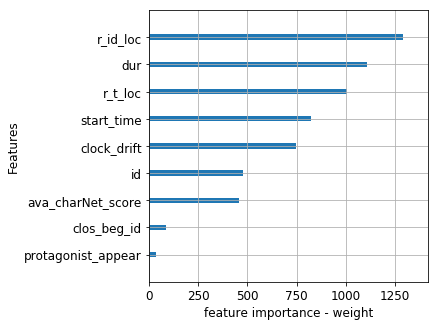

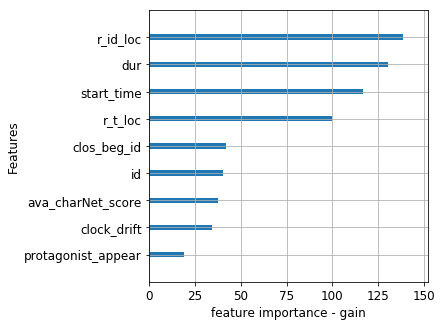

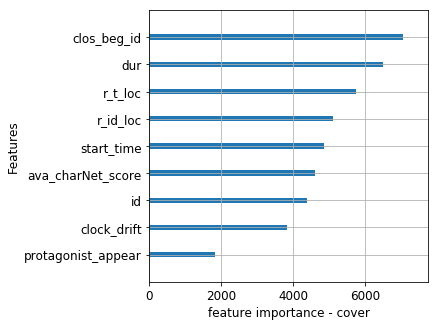

In [113]:
feature_selection_model.get_booster().feature_names = feature_list
plot_importance(feature_selection_model, title=None, xlabel='feature importance - weight', 
                importance_type='weight', show_values=False)
plot_importance(feature_selection_model, title=None, xlabel='feature importance - gain', 
                importance_type='gain', show_values=False)
plot_importance(feature_selection_model, title=None, xlabel='feature importance - cover',
                importance_type='cover', show_values=False)

# plt.rcParams['font.size'] = 12
# plt.rcParams['figure.figsize'] = [5, 5]
# plt.show()

In [50]:
for i, f in enumerate(feature_list):
    print(i, f)

0 id
1 clos_beg_id
2 r_id_loc
3 start_time
4 dur
5 r_t_loc
6 sec
7 clock_drift
8 protagonist_appear
9 ava_charNet_score


[0.07904351 0.01411491 0.21388243 0.13699767 0.18382597 0.16672201
 0.         0.12371305 0.00564596 0.07605447]


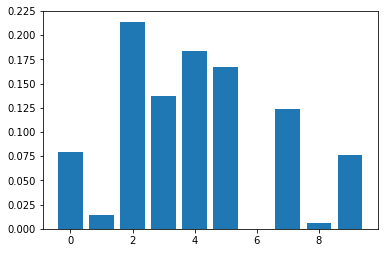

In [54]:
print(feature_selection_model.feature_importances_)
# plot
pyplot.bar(range(len(feature_selection_model.feature_importances_)), feature_selection_model.feature_importances_)
pyplot.show()

## Label wise statistical analysis

In [40]:
for i in range(10):
    xgboost_label_similarity = [ep[i] for ep in model_label_similarity['XGBoost']]
    temporal_label_similarity = [ep[i] for ep in bench_temporal_label_dist['label_similarity']]
    print("P-value for label:", label_list[i])
    print(ttest_rel(temporal_label_similarity, xgboost_label_similarity, nan_policy='omit')[1])

P-value for label: Inciting incident
0.00030242259032517074
P-value for label: Climax 1
2.8686547441116516e-05
P-value for label: Obstacle
0.01757164104151064
P-value for label: Midpoint
0.47970846692851077
P-value for label: Disaster
0.15224664672950192
P-value for label: Crisis
0.6491956530487681
P-value for label: Climax 2
0.47830049392459173
P-value for label: Climax 3
0.5530345558550355
P-value for label: Wrap-up
0.06299518314891642
P-value for label: Non-Key
4.9994242512399395e-11


In [41]:
for i in range(10):
    xgboost_label_kl = [ep[i] for ep in model_kl_divergence['XGBoost']]
    temporal_label_kl = [ep[i] for ep in bench_temporal_label_dist['label_kl_divergence']]
    print("P-value for label:", label_list[i])
    print(ttest_rel(temporal_label_kl, xgboost_label_kl, nan_policy='omit')[1])

P-value for label: Inciting incident
0.012139856156990933
P-value for label: Climax 1
6.550354708789892e-05
P-value for label: Obstacle
0.01820344109073089
P-value for label: Midpoint
0.8384014490866363
P-value for label: Disaster
0.6231705198910318
P-value for label: Crisis
0.9029716912092267
P-value for label: Climax 2
0.8188144176898707
P-value for label: Climax 3
0.22015840043596968
P-value for label: Wrap-up
0.6280372526758884
P-value for label: Non-Key
1.9845247162822096e-07


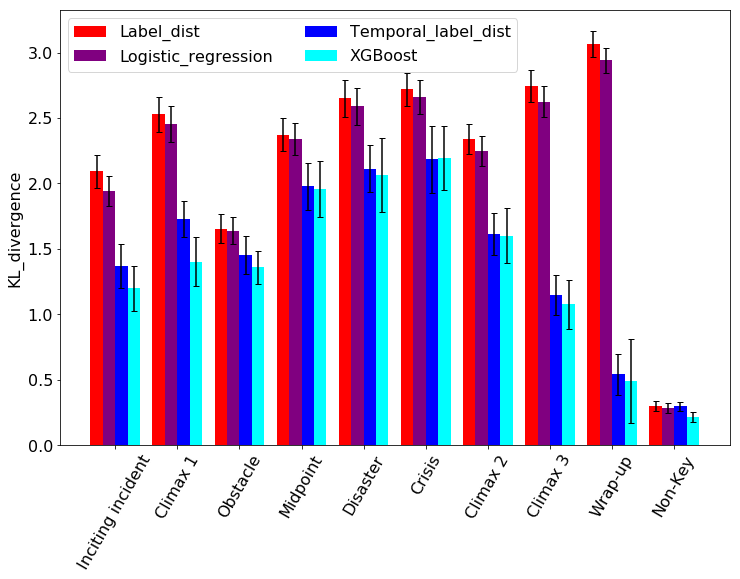

In [109]:
bar_width = 0.4
r1 = 2*np.arange(10)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

pyplot.rcParams.update({'font.size': 16})

fig = pyplot.figure(figsize=(12,8))

pyplot.bar(r1, 
           np.nanmean(bench_label_dist['label_kl_divergence'], axis=0), 
           yerr=1.95*sem(bench_label_dist['label_kl_divergence'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='red',
           label='Label_dist'
          )
pyplot.bar(r2, 
           np.nanmean(model_kl_divergence['Logistic'], axis=0), 
           yerr=1.95*sem(model_kl_divergence['Logistic'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='purple',
           label='Logistic_regression'
          )
pyplot.bar(r3, 
           np.nanmean(bench_temporal_label_dist['label_kl_divergence'], axis=0), 
           yerr=1.95*sem(bench_temporal_label_dist['label_kl_divergence'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='blue',
           label='Temporal_label_dist'
          )

pyplot.bar(r4, 
           np.nanmean(model_kl_divergence['XGBoost'], axis=0), 
           yerr=1.95*sem(model_kl_divergence['XGBoost'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='cyan',
           label='XGBoost'
          )

pyplot.xticks([2*(r + 0.75*bar_width) for r in range(10)], label_list, rotation='60')
pyplot.ylabel('KL_divergence')
pyplot.legend(ncol=2)

pyplot.show()

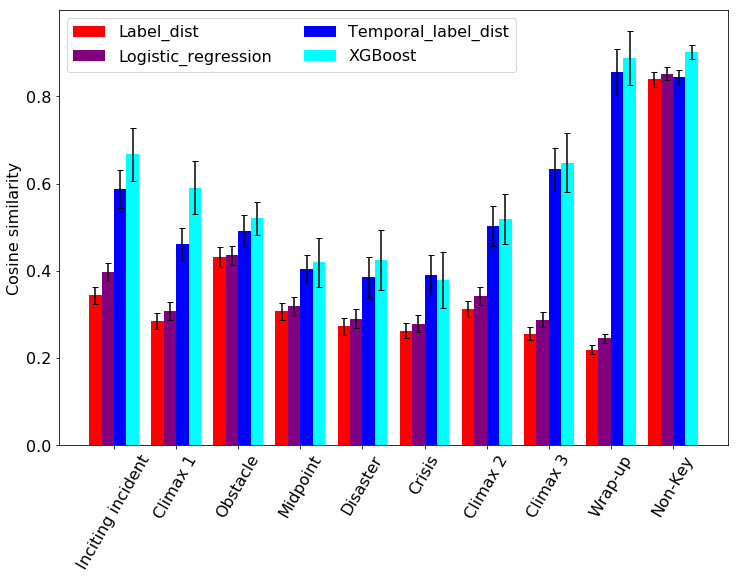

In [111]:
fig2 = pyplot.figure(figsize=(12,8))

pyplot.bar(r1, 
           np.nanmean(bench_label_dist['label_similarity'], axis=0), 
           yerr=1.95*sem(bench_label_dist['label_similarity'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='red',
           label='Label_dist'
          )
pyplot.bar(r2, 
           np.nanmean(model_label_similarity['Logistic'], axis=0), 
           yerr=1.95*sem(model_label_similarity['Logistic'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='purple',
           label='Logistic_regression'
          )
pyplot.bar(r3, 
           np.nanmean(bench_temporal_label_dist['label_similarity'], axis=0), 
           yerr=1.95*sem(bench_temporal_label_dist['label_similarity'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='blue',
           label='Temporal_label_dist'
          )

pyplot.bar(r4, 
           np.nanmean(model_label_similarity['XGBoost'], axis=0), 
           yerr=1.95*sem(model_label_similarity['XGBoost'], nan_policy='omit'),
           width=bar_width,
           capsize=3,
           color='cyan',
           label='XGBoost'
          )

pyplot.xticks([2*(r + 0.75*bar_width) for r in range(10)], label_list, rotation='60')
pyplot.ylabel('Cosine similarity')
pyplot.legend(ncol=2)

pyplot.show()